In [ ]:
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from src.clustering_methods import WassersteinKMeans, MomentKMeans
from src.clustering_eval import MMDCalculator, ClusteringMetrics
from src.utils import load_signal, segment_time_series

signal_df = load_signal("../data/SPX_hourly.csv")
prices = signal_df["Close"]
log_returns = np.log(prices).diff().dropna()

window, step = 360, 12
segments = segment_time_series(log_returns, window=window, step=step)

## MMD Comparison of WK-means vs MK-means Clusterings

Wasserstein  median MMD^2: 0.10880548368850951
Moments      median MMD^2: 0.1492025211209015


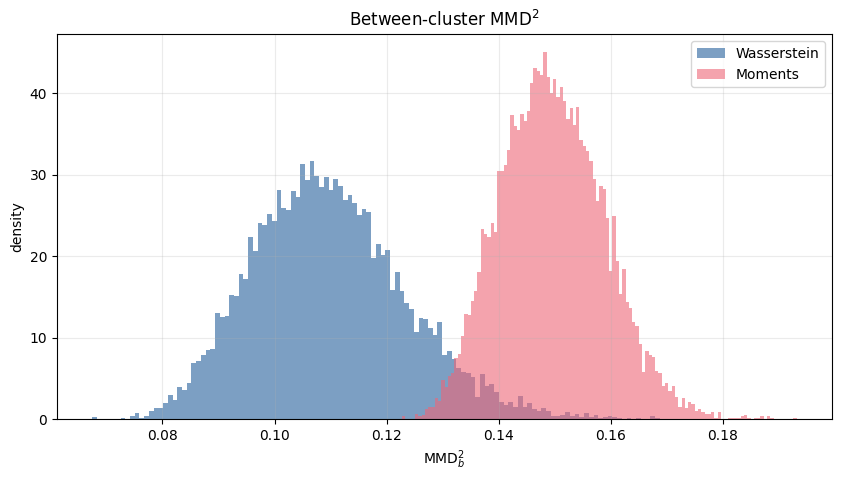

In [2]:
wk_labels = WassersteinKMeans(p_dim=2, random_state=42).fit(segments).labels
mk_labels = MomentKMeans(p_dim=2, random_state=42).fit(segments).labels
mmd = MMDCalculator(unbiased=False, random_state=42)

# (1) Optional: between-cluster comparison (earlier function)
dist_w, dist_m, _ = mmd.compare_two_clusterings_hist(segments.values.tolist(), wk_labels, mk_labels, B=10000)

print("Wasserstein  median MMD^2:", np.median(dist_w))
print("Moments      median MMD^2:", np.median(dist_m))

Wasserstein (largest cluster)  median MMD^2: 0.019821143472956826
Moments     (largest cluster)  median MMD^2: 0.020936024628963823
Wasserstein (2nd cluster)      median MMD^2: 0.021545864037228135
Moments     (2nd cluster)      median MMD^2: 0.03924770294589697


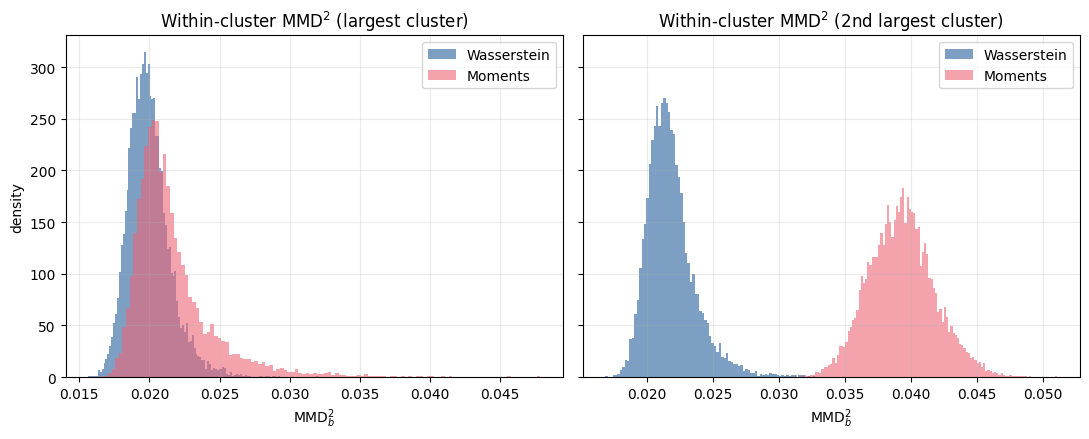

In [3]:
# (2) Within-cluster figure (two panels, like the paper)
(d_w1, d_w2, d_m1, d_m2), fig = mmd.plot_within_two_methods(segments.values.tolist(), wk_labels, mk_labels, B=10000)

print("Wasserstein (largest cluster)  median MMD^2:", np.median(d_w1))
print("Moments     (largest cluster)  median MMD^2:", np.median(d_m1))
print("Wasserstein (2nd cluster)      median MMD^2:", np.median(d_w2))
print("Moments     (2nd cluster)      median MMD^2:", np.median(d_m2))

## Other Traditional Clustering Comparison Metrics

In [4]:
def compare_wk_vs_mk(
    segments,
    wk_labels,
    mk_labels,
    alpha: float = 0.2,
    mmd_bootstrap: int = 10000,
    m_per_group: int = 40,
    random_state: int = 42,
) -> pd.DataFrame:
    """Fit WK-means and Moment K-means on `segments` and summarize their metrics."""

    metrics = ClusteringMetrics()
    mmd = MMDCalculator(random_state=random_state)

    rows = []
    for name, labels in [("Wasserstein K-means", wk_labels), ("Moment K-means", mk_labels)]:
        scores = metrics.evaluate_all(segments, labels, alpha=alpha)

        # compare the two largest clusters for the between-cluster MMD² statistic
        (largest_two, _labels) = mmd._largest_two_clusters(segments, labels)
        between = mmd.bootstrap_between(largest_two[0], largest_two[1], B=mmd_bootstrap, m_per_group=m_per_group)

        rows.append(
            {
                "method": name,
                "davies_bouldin": scores["davies_bouldin"],
                "dunn": scores["dunn"],
                "silhouette_mean": scores["silhouette_mean"],
                f"silhouette_{alpha:.1f}": scores["silhouette_alpha"],
                "mmd2 (between)": np.median(between),
            }
        )

    return pd.DataFrame(rows).set_index("method")


compare_wk_vs_mk(segments.tolist(), wk_labels, mk_labels)

,davies_bouldin,dunn,silhouette_mean,silhouette_0.2,mmd2 (between)
method,,,,,
Wasserstein K-means,43.934368,0.144774,0.363688,0.107175,0.108805
Moment K-means,9.961221,0.434232,0.740107,0.223506,0.149203
